In [492]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<b><h3>Classification</h3></b>

Data scientists are often tasked with automating decisions for business problems. Is an email an attempt at phishing? Is a customer likely to churn? Is the web user likely to click on an advertisement? These are all classification problems, a form of supervised learning in which we first train a model on data where the outcome is known and then apply the model to data where the outcome is not known. Classification is perhaps the most important form of prediction: the goal is to predict whether a record is 1 or 0 (phishing / not-phising, click/don't click, churn/don't churn), or in some cases, one of several categories (for example, Gmail's filtering of your inbox into "primary","social", "promotional" or "forums").

Often we need more than a simple binary classification: we want to know the predicted probabililty that a case belongs to a class. Rather than having a model simply assign a binary classification, most algorithms can return a probability score (propensity) of belonging to the class of interest. In Python's scikit-learn, logistic regression, like most classification methods, provides two prediction methods: predict(which returns the class) and predict_proba(which returns the probabilities for each class). A sliding cutoff can then be used to convert the propensity score to a decision. The general approach is as follows:
1. Establish a cutoff probability for the class of interest, above which we consider a record as belonging to that class.
2. Estimate (with any model) the probability that a record belongs to the class of interest.
3. If that probability is above the cutoff probability, assign the new record to the class of interest.

The higher the cutoff, the fewer the records predicted as 1- that is, as belonging to the class of interest. The lower the cutoff, the more the records predicted as 1.

<b><h4>More Than Two Categories</h4></b>

The vast majority of problems involve a binary response. Some classification problems, however, involve a response with more than two possible outcomes. For example, at the anniversary of a customer's subscription contract, there might be three outcomes: the customer leaves or "churns" (Y=2), goes on a month-to-month contract (Y=1), or signs a new long-term contract (Y=0). The goal is to predict Y = j for j = 0, 1, 2. Most of the classification methods can be applied, either directly with modest adaptations, to responses that have more than two outcomes. Even in the case of more than two outcomes, the problem can often be recast into a series of binary problems using conditional probabilities. For example, to predict the outcome of the contract, you can solve two binary prediction problems:

- Predict whether Y = 0 or Y > 0.
- Given that Y > 0, predict whether Y = 1 or Y = 2.

In this case, it makes sense to break up the problem into two cases: (1) whether the custome churns, and (2) if they don't churn, what type of contract they will choose. From a model-fitting viewpoint, it is often advantageous to convert the multiclass problem into a series of binary problems. This is particularly true when one category is much more common than the other categories.

<b><h3>Naive Bayes</h3></b>

The naive Bayes algorithm uses the probability of observing predictor values, given an outcome, to estimate what is really of interest: the probability of observing outcome Y = i, given a set of predictor values. To understand naive Bayes classification, we can start out by imagining complete or exact Bayesian classification. For each record to be classified:
1. Find all the other records with the same predictor profile (ie, where the predictor values are the same).
2. Determine what classes those records belong to and which class is most prevalent (ie. probable).
3. Assign that class to the new record.

The preceding approach amounts to finding all the records in the sample that are exactly like the new record to be classified in the sense that all the predictor values are identical. Predictor variables must be categorical (factor)
variables in the standard naive Bayes algorithm. There are workarounds for using continuous variables.

<b><h4>Why Exact Bayesian Classification Is Impractical</h4></b>

When the number of predictor variables exceeds a handful, many of the records to be classified will be without exact matches. Consider a model to predict voting on the basis of demographic variables. Even a sizable sample may not contain even a single match for a new record who is a male, Hispanic, with high income, form the US Mid-west, who voted in the last election, did not vote in the prior election, has three daughters and one son, and is divorced. And this is with just eight variables, a small number for most classification problems. The addition of just a single new variable with five equally frequent categories reduces the probability of a match by a factor of 5.

<b><h4>The Naive Solution</h4></b>

In the naive Bayes solution, we no longer restrict the probability calculation to those records that match the record to be classified. Instead, we use the entire data set. The naive Bayes modification is as follows:

1. For a binary response Y = i (i=0 or 1), estimate the individual conditional probabilities for each predictor $P(X_j|Y=i)$; these are the probabilities that the predictor value is in the record when we observe Y=i. This probability is estimated by the proportion of $X_j$ values among the $Y=i$ records in the training set.
2. Multiply these probabilities by each other (probabilities for each predictor), and then by the proportion of records, belonging to Y=i.
3. Repeat steps 1 and 2 for all classes.
4. Estimate a probability for outcome i by taking the value calcualted in step 2 for class i and dividing it by the sum of such variables for all classes.
5. Assign the record to the class with the highest probability for this set of predictor values.

This naive Bayes algorithm can also be stated as an equation for the probability of observing outcome $Y=i$, given a set of predictor values $X_1\;,...\;,X_p$ : $P(Y=i|X_1,X_2,...,X_p)$
Here is a full formula for calculating class probabilities using exact Bayes classification:

$P(Y=i|X_1,X_2,...,X_p)=$ $\dfrac{P(Y=i)P(X_1,...Xp|Y_i)}{P(Y=0)P(X_1,...,X_p|Y=0)+P(Y=1)P(X_1,...,X_p|Y=1)}$

Under the naive Bayes assumption of conditional independence, this equation changes into:

$P(Y=i|X_1lX_2,...,X_p)=$ $\dfrac{P(Y=i)P(X_1|Y=i)...P(X_p|Y=i)}{P(Y=0)P(X_1|P=0)...P(X_p|Y=0)+P(Y=1)P(X_1|Y=1)...P(X_p|Y=1)}$ 

Why is this formula called "naive"? We have made a simplifying assumption that the exact conditional probability of a vector of predictor values, given observing an outcome, is sufficiently well estimated by the product of the individual conditional probabilities $P(X_j|Y=i)$. In other words, in estimating $P(X_j|Y=i)$ instead of P(X_1,X_2,...,X_p|Y=i), we are assuming $X_j$ is independent of all the other predictor variables $X_k$ for  $k\neq j$.

In Python, we can use sklearn.naive_bayes.MultinomialNB from scikit-learn. We need to convert categorical features to dummy variables before we fit the model.


In [493]:
loan_data = pd.read_csv('../data/loan_data.csv.gz')

# categorical types
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default']) # reorder what is considered class 1
loan_data.purpose_ = loan_data.purpose.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,car,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [494]:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

loan_data[predictors].head()

,purpose_,home_,emp_len_
0,car,RENT,> 1 Year
1,small_business,OWN,> 1 Year
2,other,RENT,> 1 Year
3,debt_consolidation,RENT,> 1 Year
4,other,RENT,> 1 Year


In [495]:
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True) #alpha is smoothing parameter
naive_model.fit(X,y)

MultinomialNB(alpha=0.01)

It is possible to derive the conditional probabilities from the fitted model using the property feature_log_prob_. The model can be used to predict the outcome of a new loan.

scikit-learn's classification models have two methods - predict which returns the predicted class and predict_proba, which returns the class probabilities.

In [496]:
new_loan = X.loc[146:146,:] # loc is inclusive
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


In [497]:
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan), columns=loan_data[outcome].cat.categories)

In [498]:
probabilities

,default,paid off
0,0.653696,0.346304


The prediction also returns a posterior estimate of the probability of default  (the class). The naive Bayesian classifier is known to produce biased estimates. However, where the goal is to rank records according to the probability that Y = 1, unbiased estimates of probability are not needed, and naive Bayes produces good results.

<b><h4>Numerical Predictor Variables</h4></b>

The Bayesian classifier works only with categorical predictors (eg with spam classifier, where the prescence or absence of words, phrases, characters, and so on lies at the heart of the predictive task). To apply naive Bayes to numerical predictors, one of two approaches must be taken:

- Bin and convert the numerical predictors to categorical predictors and apply the algorithm.
- Use a probability model - for example, the normal distribution - to estimate the conditional probability $P(X_j|Y=i)$

When a predictor category is absent in the training data, the algorithm assigns zero probability to the outcome variable in new data, rather than simply ignoring this variable, as other methods might. Most implementations of Naive Bayes use a smoothing parameter (Laplace Smoothing) to prevent this.

Remember Naive Bayes works with categorical (factor) predictors and outcomes. It asks "Within each outcome category, which predictor categories are most probable?". That information is then inverted to estimate probabilities of outcome categories, given predictor values.

<b><h3>Discriminant Analysis</h3></b>

$Discriminant\;analysis$ is the earliest statistical classifier. While discriminant analysis encompasses several techniques, the most commonly used is linear discriminant analysis, or LDA. The original method was actually a slightly different from LDA, but the mechanics are essentially the same. LDA is now less widely used with the advent of more sophisticated techniques, such as tree models and logistic regression. Linear discriminant analysis should not be confused with Latent Dirichlet Allocation, also referred to as LDA. Latent Dirichlet Allocation is used in text and natural language processing and is unrelated to linear discriminant analysis.

<b><h4>Covariance Matrix</h4></b>

To understand discriminant analysis, it is first necessary to introduce the concept of covariance between two or more variables. The covariance measures the relationship between two variables $x$ and $z$. Denote the mean for each variable by $\bar x$ and $\bar z$. The covariance $s_{x,z}$ is given by:

$s_{x,z} = $  $\dfrac{\sum_{i=1}^n(x_i - \bar x_i)(z_i - \bar z_i)}{n-1}$

where $n$ is the number of records (note that we divide by n-1 instead of n, degrees of freedom).

As with the correlation coefficient, positive values indicate a positive relationship and negative values indicate a negative relationship. Correlation, however, is constrained to be between -1 and 1, whereas covariance scale depends on the scale of the varaibles $x$ and $z$. The $covariance\;matrix\;\sum$ for $x$ and $z$, consists of the individual variable variances, $s_x^2$ and $s_z^2$ on the diagonal (where row and column are the same variable) and covariances between variable pairs on the off-diagonals.

$\hat\sum$  = $\begin{bmatrix} s_x^2 & s_{x,z} \\ s_{z,x} & s_z^2 \end{bmatrix}$

Recall that the standard deviation is used to normalize a variable to a z-score; the covariance matrix is used in a multivariate extension of this standardization process.

<b><h4>Fischer's Linear Discriminant</h4></b>

For simplicity, let's focus on a classification problem in which we want to predict a binary outcome y using just two continuous numeric variables (x,z). Technically, discriminant analysis assumes the predictor variables are normally distributed continuous variables, but, in practice, the method works well even for nonextreme departures from normality, and for binary predictors. Fisher's linear discriminant distinguishes variation between groups, on the one hand, from variation within groups on the other. Specifically, seeking to divide the records into two groups, linear discriminant analysis (LDA) focuses on maximizing the "between" sums of squares $SS_{between}$ (measuring the variation between the two groups) relative to the "within" sum of squares $SS_{within}$ (measuring the within-group variation). In this case, the two groups correspond to the records $(x_0,z_0)$ for which y=0 and the record $(x_1,z_1)$ for which y = 1. The method finds the linear combination $w_xx+w_zz$ that maximizes the sum of squares ratio:

$\dfrac{SS_{between}}{SS_{within}}$

The between sum of squares is the squared distance between the two group means, and the within sum of squares is the spread around the means within each group, weighted by the covariance matrix. Intuitively, by maximizing the between sum of squares and minimizing the within sum of squares, this method yields the greatest separation between the two groups.

If the predictor variables are normalized prior to running LDA, the discriminator weights are measures of variable importance, thus providing a computationally efficient method of feature selection.

<b><h4>A Simple Example</h4></b>

We apply an LDA function to a sample of loan data using two predictor variables, borrower_score and payment_inc_ratio. In Python, we can use LinearDiscriminantAnalysis() from sklearn.discriminant_analysis. The scalings_ property gives the estimated weights.

In [499]:
loan3000 = pd.read_csv('../data/loan3000.csv')
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [500]:
loan3000.outcome = loan3000.outcome.astype('category')

In [501]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

In [502]:
X = loan3000[predictors]
y = loan3000[outcome]

In [503]:
loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X,y)
pd.DataFrame(loan_lda.scalings_, index=X.columns)

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


The predict_proba() method of the fitted model return the probabilities for the 'default' and 'paid_off' outcomes. A plot of predictions helps illustrate how LDA works.

In [504]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]), columns=loan_lda.classes_)
pred['actual'] = loan3000.outcome
pred.head()

,default,paid off,actual
0,0.553544,0.446456,paid off
1,0.558953,0.441047,default
2,0.272696,0.727304,paid off
3,0.506254,0.493746,paid off
4,0.609952,0.390048,default


In [505]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)                   # mean of each column
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]     # ratio of coefficients, slope 
intercept = center[1] - center[0] * slope                   # intercept o

# payment_inc_ratio for borrower of score 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio,default
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135,0.553544
1,16982,default,credit_card,15.49,0.40,5.43165,0.558953
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003,0.272696
3,34580,paid off,major_purchase,21.11,0.40,2.33482,0.506254
4,14424,default,debt_consolidation,16.46,0.45,12.10320,0.609952


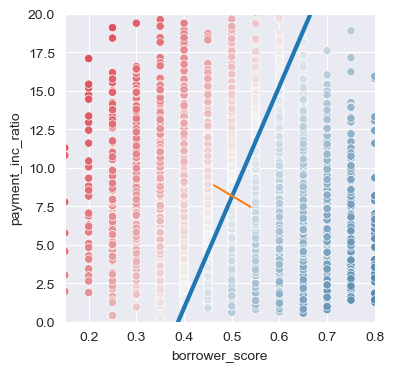

In [506]:
fig, ax = plt.subplots(figsize=(4,4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio', hue='default', data=lda_df,
                    palette=sns.diverging_palette(240,10,n=9,as_cmap=True), ax=ax, legend=False)
ax.set_ylim(0,20)
ax.set_xlim(0.15,0.8)
ax.plot((x_0,x_20), (0,20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())


Using the discriminant function weights, LDA splits the predictor space into two regions, as shown by the solid line. The predictions farther away from the line in both directions have a higher level of confidence (ie, a probability further from 0.5).

LDA works just as well with more than two predictor variables. The only limiting factor is the number of records (estimating the covariance matrix requires a sufficient number of records per variable). There are other variants of discriminant analysis. Quadratic discriminant analysis (QDA) is still a linear discriminant function. The main difference is that in LDA, the covariance matrix is assumed to be the same for the two groups corresponding to Y=0 and Y=1. In QDA, the covariance matrix is allowed to be different for the two groups.

<b><h3>Logistic Regression</h3></b>

Logistic regression is analogous to multiple linear regression, except the outcome is binary. Various transformations are employed to convert the problem to one in which a linear model can be fit. Like discriminant analysis, and unlike K-Nearest Neighbor and naive Bayes, logistic regression is a structured model approach rather than a data-centric approach. Due to its fast computational spped and its output of a model that lends itself to rapid scoring of new data, it is a popular method.

<b><h4>Logistic Response Function and Logit</h4></b>

The key ingredients for logistic regression are the logistic response function and the logit, in which we map a probability (which is on a 0-1 scale) to a more expansive scale suitable for linear modeling.

The first step is to think of the outcome variable not as a binary label but as the probability p that the label is 1. Naively, we might be tempted to model p as a linear function of the predictor variables.

$p=\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_qx_q$

However, fitting this model does not ensure that $p$ will end up between 0 and 1, as a probability must. Instead we model $p$ by applying a logistic response or inverse logit function to the predictors.

$p=\dfrac{1}{1+e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_qx_q)}}$

This transformation ensures tha p stays between 0 and 1. 

To get the exponential expression out of the denominator, we consider odds instead of probabilities. Odds, familiar to bettors everywhere, are the ratio of success (1) to nonsuccess (0). In terms of probabilities, odds are the probability of an event divided by the probability that the event will not occur. For example, if the probability that a horse will win is 0.5, the probability of "won't win" is (1-0.5)=0.5, and the odds are 1:

$Odds(Y=1) = \dfrac{p}{1-p}$

We can obtain the probability from the odds using the inverse odds function:

$p = \dfrac{Odds}{1+Odds}$

We combine this with the logistic response function to get:

$Odds(Y=1)= e^{\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_qx_q}$

Finally, taking the logarithm of both sides, we get an expression that involves a linear function of the predictors:

$log(Odds(Y=1))=\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_qx_q$

The log-odds function, also known as the logit function, maps the probability from (0,1) to any value $(-∞,+∞)$. The transformation circle is complete; we have used a linear model to predict a probability, which we can in turn map to a class label by applying a cutoff rule - any record with a probability greater than the cutoff is classified as 1.

<b><h4>Logistic Regression and the GLM</h4></b>

The response in the logistic regression formula is the log odds of a binary outocme of 1. We observe only the binary outcome, not the log odds, so special statistical methods are needed to fit the equation. Logistic regression is a special instance of a generalized linear model (GLM) developed to extend linear regression to other settings.

In Python, we use the scikit-learn class LogisticRegression() from sklearn.linear_model. The arguments penalty and C are used to prevent overfitting by L1 or L2 regularaization. Regularization is switched on by default. In order to fit without regularization w set C to a very large value. The solver argument selects the used minimizer; the method liblinear is the default:


In [507]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', drop_first=True)
y = loan_data[outcome]       # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X,y)

LogisticRegression(C=1e+42, solver='liblinear')

In [508]:
print('intercept ', logit_reg.intercept_[0])
print('classes ', logit_reg.classes_)
pd.DataFrame({
    'coef': logit_reg.coef_[0],  # 2D (1,1) so select first (and only)
}, index=X.columns)

intercept  -1.8355185839159172
classes  ['default' 'paid off']


,coef
payment_inc_ratio,-0.080000
borrower_score,4.605058
credit_card,0.208896
debt_consolidation,-0.040323
home_improvement,-0.200081
house,-0.195597
major_purchase,-0.034457
medical,-0.300962
moving,-0.467877
other,-0.464216


In [509]:
print(loan_data.purpose_.cat.categories)
print(loan_data.emp_len_.cat.categories)
print(loan_data.home_.cat.categories)

Index(['car', 'credit_card', 'debt_consolidation', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'small_business',
       'vacation', 'wedding'],
      dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')


If you have a feature or outcome variable that is ordinal (ie ordered in value) use the scikit-learn class OrdinalEncoder() to replace the categories with numbers. When we apply this to our outcome variable in the loan_data example, the resulting coefficients have reversed signs because we reverse the classes below ie paid off is class 1.

In [510]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

In [511]:
y_enc

array([1., 1., 1., ..., 0., 0., 0.])

In [512]:
logit_reg_enc = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes ', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, index=X.columns)

intercept  1.8355194685213252
classes  [0. 1.]


,coeff
payment_inc_ratio,0.080000
borrower_score,-4.605057
credit_card,-0.208896
debt_consolidation,0.040323
home_improvement,0.200080
house,0.195596
major_purchase,0.034456
medical,0.300961
moving,0.467876
other,0.464217


<b><h4>Generalized Linear Models</h4></b>

Generalized linear models (GLMs) are characterized by two main components:
- A probability distribution or family (binomial in the case of logistic regression)
- A link function - i.e, a transformation function that maps the response to the predictors (logit in the case of logistic regression)

Logistic regressiion is by far the most common form of GLM. A data scientist will encounter other types of GLMs. Sometimes a log link function is used instead of the logit; in practice, use of a log link is unlikely to lead to very different results for most applications. The Poisson distribution is commonly used to model count data (e.g, the number of times a user visits a web page in a certain amount of time). Other families include negative binomial and gamma, often used to model elapsed time (eg time to failure). In contrast to logistic regression, application of GLMs with these models is more nuanced and involves greater care. 


<b><h4>Predicted Valus From Logistic Regression</h4></b>

The predicted value from logistic regression is in terms of the log odds: $\hat Y = log(Odds(Y=1))$. The predicted probability is given by the logistic response function:

$\hat p = \dfrac{1}{1 + e^{-Y}}$

In Python, we can access the log odds via predict_log_proba(), and actual probabilities via predict_proba(). The probabilities are on a scale from 0 to 1 and don't yet declare whether a predicted value is default or paid off. We could declare any value greater than 0.5 as default. In practice, a lower cutoff is often appropriate if the goal is to identify members of a rare class.

In [513]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X), columns=loan_data[outcome].cat.categories)
pred.head()

,default,paid off
0,-1.431977,-0.272907
1,-1.157687,-0.377187
2,-0.634370,-0.755596
3,-0.530176,-0.887950
4,-0.751292,-0.638199


In [514]:
pred = pd.DataFrame(logit_reg.predict_proba(X), columns=loan_data[outcome].cat.categories)
pred.head()

,default,paid off
0,0.238836,0.761164
1,0.314212,0.685788
2,0.530269,0.469731
3,0.588502,0.411498
4,0.471757,0.528243


In [515]:
pred = pd.DataFrame(logit_reg.predict(X), columns=['outcome'])
pred.head()

,outcome
0,paid off
1,paid off
2,default
3,default
4,paid off


<b><h4>Interpreting the Coefficients and Odds Ratios</h4></b>

One advantage of logistic regression is that produces a model that can be scored to new data rapidly, without recomputation. Another is the relative ease of interpretation of the model, as compared with other classification methods. The key conceptual idea is understanding an odds ratio. The odds ratio is easiest to understand for a binary factor variable X:

$odds\;ratio=\dfrac{Odds(Y=1|X=1)}{Odds(Y=1|X=0)}$

This is interpreted as the odds that Y = 1 when X = 1 versus the odds that Y = 1 when X = 0. If the odds ratio is 2, then the odds that Y = 1 are two times higher when X = 1 versus when X = 0. Why bother with an odds ratio rather than probabilities? We work with odds because the coefficient $\beta_j$ in the logistic regression is the log of the odds ratio for $X_j$. 

Odds ratios for numeric variables X can be interpreted as follows: they measure the change in the odds ratio for a unit change in X. For example, the effect of increasing the payment-to-income ratio from, say, 5 to 6 increases the odds of the loan defaulting by a factor of exp(0.0800) ~ 1.08. The variable borrower_score is a score on the borrower's credit worthiness and ranges from 0 (low ) to 1 (high). The odds of the best borrowers relative to the worst borrowers defaulting on their loans is smaller by a factor exp(-4.605057) ~ 0.01. In other words, the default risk from the borrowers with the poorest creditworthiness is 100 times greater than that of the best borrowers.

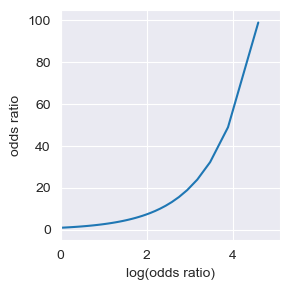

In [516]:
p = np.arange(0.01, 1.0, 0.01)
df = pd.DataFrame({
    'p' : p,
    'logit': np.log(p/(1-p)),
    'odds' : p/(1-p)
})

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)
plt.tight_layout()

In [517]:
np.exp(0.0800)

1.0832870676749586

In [518]:
np.exp(-4.605057)

0.010001131923938667

<b><h4>Linear and Logistic Regresssion: Similarities and Differences</h4></b>

Linear regression and logistic regression share many commonalities. Both assume a parametric linear form relating the predictors with the response. Exploring and finding the best model are done in very similar ways. Extensions to the linear model, like the use of a spline transform of a predictor are equally applicable in the logistic regression setting. Logistic regression differs in two fundamental ways:
- The way the model is fit (least squares is not applicable)
- The nature and analysis of the residuals from the model.

<b><h5>Fitting the model</h5></b>

Linear regression is fit using least squares, and the quality of the fit is evaluated using RMSE and R-Squared statistics. In logistic regression (unlike in linear regression), there is no closed form solution, and the model must be fit using maximum likelihood estimation (MLE). Maximum likelihood estimation is a process that tries to find the model that is most likely to have produced the data we see. In the logistic regression equation, the response is not 0 or 1 but rather an estimate of the log odds that the response is 1. The MLe finds the solution such that the estimated log odds best describes the observed outcome. The mechanics of the algorithm involve a quasi-Newton optimization that iterates between a scoring step (Fisher's scoring), based on the current parameters, and an update to the parameters to improve the fit.

<b><h5>Maximum Likelihood Estimation</h5></b>

Start with a set of data $(X_1, X_2, ... , X_n)$ and a probability model $P_\theta(X_1, X_2, ... , X_n)$ that depends on a set of parameters $\theta$. The goal of MLE is to find the set of parameters $\hat \theta$ that maximizes the value of of $P_\theta(X_1, X_2, ... , X_n)$; that is, it maximizes the probability of observing $(X_1, X_2, ... , X_n)$
given the model P. In the fitting process, the model is evaluated using a metric called deviance:

$deviance = -2log(P_{\hat\theta}(X_1, X_2, ... , X_n))$

Lower deviance corresponds to a better fit.

<b><h4>Assessing the Model</h4></b>

Like other classification methods, logistic regression is assessed by how accurately the model classifies new data. The statsmodels package has an implementation for generalized linear model (GLM). Along with the estimate coefficients, statsmodels reports the standard error of the coefficients (SE), a z-value, and a p-value.

Interpretation of the p-value comes with the same caveat as in regression and should be viewed more as a relative indicator of variable importance than as a formal measure of statistical significance. A logistic regression model, which has a binary response, does not have an associated RmSM or R-squared. Insted a logistic regression model is typically evaluated using more general metrics for classification.

Many other concepts for linear regression carry over to the logistic regression setting (and other GLMs). For example, you can use stepwise regression, fit interaction terms or include spline terms. The same concerns regarding confounding and correlated variables apply to logistic regression. The formula interface of statsmodels also supports these extensions in Python.

In [519]:
y_numbers = [1 if yi == 'default' else 0 for yi in y] # encode
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45325
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28744.
Date:                Thu, 21 Sep 2023   Deviance:                       57488.
Time:                        16:04:20   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1117
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0800      0.002     32.100      0.000       0.075       0.085
borrower_score        -4.6073      0.084    -55.120      0.000      -4.771      -4.443
credit_card           -0.2082      0.082     -2.553      0.011      -0.368      -0.048
debt_consolidation     0.0411      0.079      0.520      0.603      -0.114       0.196
home_improvement       0.2005      0.088      2.270      0.023       0.027       0.374
house                  0.1982      0.135      1.469      0.142      -0.066       0.463
major_purchase         0.0350      0.098      0.358      0.720      -0.157       0.227
medical                0.3031      0.113      2.671      0.008       0.081       0.526
moving                 0.4707      0.126      3.741      0.000       0.224       0.717
other                  0.4652      0.085      5.461      0.000       0.298       0.632
small_business         1.0069      0.097     10.369      0.000       0.817       1.197
vacation               0.4985      0.145      3.443      0.001       0.215       0.782
wedding               -0.0244      0.120     -0.203      0.839      -0.259       0.210
OWN                    0.0469      0.038      1.234      0.217      -0.028       0.122
RENT                   0.1586      0.021      7.456      0.000       0.117       0.200
 > 1 Year             -0.3510      0.053     -6.667      0.000      -0.454      -0.248
const                  1.8354      0.104     17.570      0.000       1.631       2.040
======================================================================================
"""

In [520]:
import statsmodels.formula.api as smf

formula = ('outcome ~ bs(payment_inc_ratio, df=4) + purpose_ + ' +
            'home_ + emp_len_ + bs(borrower_score, df=4)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45319
Model Family:                                       Binomial   Df Model:                           22
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28730.
Date:                                       Thu, 21 Sep 2023   Deviance:                       57461.
Time:                                               16:04:21   Pearson chi2:                 4.54e+04
No. Iterations:                                            5   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.0413      0.387      5.280      0.000       1.284       2.799
purpose_[T.credit_card]           -0.2201      0.082     -2.691      0.007      -0.380      -0.060
purpose_[T.debt_consolidation]     0.0289      0.079      0.365      0.715      -0.126       0.184
purpose_[T.home_improvement]       0.1949      0.088      2.204      0.028       0.022       0.368
purpose_[T.house]                  0.1934      0.135      1.432      0.152      -0.071       0.458
purpose_[T.major_purchase]         0.0337      0.098      0.344      0.731      -0.158       0.226
purpose_[T.medical]                0.2999      0.114      2.640      0.008       0.077       0.523
purpose_[T.moving]                 0.4772      0.126      3.789      0.000       0.230       0.724
purpose_[T.other]                  0.4623      0.085      5.424      0.000       0.295       0.629
purpose_[T.small_business]         1.0051      0.097     10.334      0.000       0.815       1.196
purpose_[T.vacation]               0.4892      0.145      3.372      0.001       0.205       0.774
purpose_[T.wedding]               -0.0270      0.120     -0.225      0.822      -0.262       0.208
home_[T.OWN]                       0.0470      0.038      1.237      0.216      -0.028       0.122
home_[T.RENT]                      0.1593      0.021      7.487      0.000       0.118       0.201
emp_len_[T. > 1 Year]             -0.3484      0.053     -6.618      0.000      -0.452      -0.245
bs(payment_inc_ratio, df=4)[0]     0.0218      0.121      0.180      0.857      -0.215       0.259
bs(payment_inc_ratio, df=4)[1]     1.6124      0.142     11.349      0.000       1.334       1.891
bs(payment_inc_ratio, df=4)[2]     1.9360      0.488      3.969      0.000       0.980       2.892
bs(payment_inc_ratio, df=4)[3]    -0.8900      1.925     -0.462      0.644      -4.662       2.882
bs(borrower_score, df=4)[0]       -1.0110      0.476     -2.124      0.034      -1.944      -0.078
bs(borrower_score, df=4)[1]       -2.6430      0.287     -9.208      0.000      -3.206      -2.080
bs(borrower_score, df=4)[2]       -3.7021      0.473     -7.826      0.000      -4.629      -2.775
bs(borrower_score, df=4)[3]       -5.8490      0.525    -11.141      0.000      -6.878      -4.820
==================================================================================================
"""

<b><h4>Analysis of residuals</h4></b>

One area where logistic regression differs from linear regression is in the analysis of the residuals. Below is Python code for generating partial residuals.

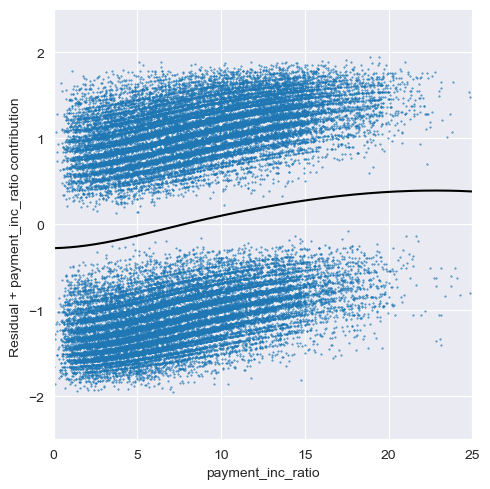

In [521]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s== 'default' else 1 for s in df[outcome]]  
    y_pred = model.predict(df)  
    org_params = model.params.copy()  
    zero_params = model.params.copy()
    # set model parameters of other features to 0
    for i,name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature' : df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial' : ypartial / 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker='.', s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Residual + {feature} contribution ")
    return ax

fig, ax = plt.subplots(figsize=(5,5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

<b><h3>Evaluating Classification Models</h3></b>

It is common in predictive modeling to train a number of different models, apply each to a holdout sample, and assess their performance. Sometimes, after a number of models have been evaluated and tuned, and if there are enough data, a third holdout sample, not previously used, is used to estimate how the chosen model will perform with completely new data. Different disciplines and practitioners will also use the terms validation and test to refer to the holdout samples. Fundamentally, the assessment process attempts to learn which model produces the most accurate and useful predictions.

A simple way to measure classification performance is to count the proportion of predictions that are correct, ie measure the accuracy. Accuracy is simply a measure of total error:

$accuracy = \dfrac{\sum True Positive + \sum True Negative}{SampleSize}$

In most classification algorithms, each case is assigned an "estimated probability of being a 1". The default decision point or cutoff, is typically 0.50 or 50%. If the probability is above 0.5, the classification is "1"; otherwise it is "0". An alternative default cutoff is the prevalent probability of 1s in the data.

<b><h4>Confusion Matrix</h4></b>

At the heart of classification metrics is the confusion matrix. The confusion matrix is a table showing the number of correct and incorrect predictions categorized by type of response.

In [522]:
pred = logit_reg.predict(X)                     # prediction
pred_y = logit_reg.predict(X) == 'default'      # boolean if class 1 was predicted
true_y = y == 'default'                         # boolean if actual label was class 1
true_pos = true_y & pred_y                      # prediction of class 1 was correct
true_neg = ~true_y & ~pred_y                    # prediction of class 0 was correct
false_pos = ~true_y & pred_y                    # prediction of class 1 was actually class 0
false_neg = true_y & ~pred_y                    # prediction of class 0 was actually class 1

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)],
                            [np.sum(false_pos), np.sum(true_neg)]],
                            index=['Y = default', 'Y = paid off'],
                            columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14354             8317
Y = paid off            8135            14536


The predicted outcomes are the columns and the true outcomes are the rows (index) in the confusion matrix above. The diagonal elements of the matrix show the number of correct predictions, and the off-diagonal elements show the number of incorrect predictions.

One important metric not explicitly called out is the false positive rate (the mirror image of precision). When 1s are rare, the ratio of false positives to all predicted positives can be high, leading to the unintuitive situation in which a predicted 1 is most likely a 0. This problem plagues medical screening tests (eg mammograms) that are widely applied: due to the relative rarity of the condition, positive test results most likely do not mean breast cancer. This leads to much confusion in the public.

<b><h4>The Rare Class Problem</h4></b>

In many cases, there is an imbalance in the classes to be predicted, with one class much more prevalent than the other - for example, legitimate insurance claims versus fraudulent ones, or browsers versus purchasers at a website. The rare class (eg the fraudulent claims) is usually the class of more interest and is typically designated 1, in contrast to the more prevalent 0s. In the typical scenario, the 1s are the more important case, in the sense that misclassifying them as 0s is costlier than misclassifying 0s as 1s. For example, correctly identifying a fraudulent insurance claim may save thousands of dollars. On the other hand, correctly identifying a nonfraudulent claim merely saves you the cost and effort of going through the claim by hand with a more careful review (which is what you would do if the claim were tagged as "fraudulent").

In such cases, unless the classes are easily separable, the most accurate classification model may be one that simply classifies everythin as 0. For example, if only 0.1% of the browsers at a web store end up purchasing, a model that predicts that each browser will leave without purchasing will be 99.9% accurate. However, it will be useless. Instead, we would be happy with a model that is less accurate overall but is good at picking out the purchasers, even if it misclassifies some nonpurchasers along the way.

<b><h4>Precision, Recall, and Specificity</h4></b>

Metrics other than pure accuracy - metrics that are more nuanced - are commonly used in evaluating classification models. Several of these have a long history in statistics - especially biostatistics, where they are used to describe the expected performance of diagnostic tests. The $precision$ measures the accuracy of the predicted positive outcome.

$precision=\dfrac{\sum True\;Positive}{\sum Predicted\;Positive}=\dfrac{\sum True\;Positive}{\sum True\;Positive\;+\;\sum False\;Positive}$

The $recall$, also known as $sensitivity$, measures the strength of the model to predict a positive outcome - the proportion of 1s that it correctly identifies. The term sensitivity is used a lot in biostatistics and medical diagnosis, whereas recall is used more in the machne learning community. The definition of recall is:

$recall\;(sensitivity)=\dfrac{\sum True\;Positive}{\sum Actual\;Positive}=\dfrac{\sum True\;Positive}{\sum True\;Positive\;+\;\sum False\;Negative}$

Another metric used is $specificity$, which measures a model's ability to predict a negative outcome. Specificity is like the opposite of sensitivity (recall) ie specificity is to the negative outcome what sensitivity (recall) is to the positive outcome:

$specificity=\dfrac{\sum True\;Negative}{\sum Actual\;Negative}=\dfrac{\sum True\;Negative}{\sum True\;Negative\;+\;\sum False\;Positive}$


scikit-learn has a confusion_matrix() function from sklearn.metrics for the confusion matrix, which puts the actual on the index and the predicted on the columns. It also has a custom method precision_recall_fscore_support() that calculates precision and recall / specificity all at once for all the labels ( positive class and negative class), and the arrangement is again actual on the index, predicted on the rows.

In [523]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
conf_mat # matches the previous manual calculation, actual on index, predicted on rows

array([[14354,  8317],
       [ 8135, 14536]])

In [524]:
print('Precision', conf_mat[0,0]/sum(conf_mat[:,0]))

Precision 0.6382675974921073


In [525]:
print('Recall', conf_mat[0,0]/sum(conf_mat[0,:]))

Recall 0.6331436637113493


In [526]:
print('Specificity', conf_mat[1,1]/sum(conf_mat[1,:]))

Specificity 0.6411715407348595


In [527]:
precision_recall_fscore_support(y, logit_reg.predict(X), labels=['default','paid off'])

(array([0.6382676 , 0.63606529]),
 array([0.63314366, 0.64117154]),
 array([0.63569531, 0.63860821]),
 array([22671, 22671]))

<b><h4>ROC Curve</h4></b>

There is a trade-off between recall and specificity. Capturing more 1s generally means misclassifying more 0s as 1s. The ideal classifier would do an excellent job of classifying the 1s, without misclassifying more 0s as 1s. The metric that captures this trade-off is the "Receiver Operating Characteristics" curve, usually referred to as the ROC curve. The ROC curve plots recall (sensitivity) on the y-axis against specificity on the x-axis. The ROC curve shows the trade-off between recall and specificity as you change the cutoff to determine how to classifiy a record. Sensitivity (recall) is plotted on the y-axis, and you may encounter two forms in which the x-axis is labeled:

- Specificity plotted on the x-axis, with 1 on the left and 0 on the right
- 1-Specificity plotted on the x-axis, with 0 on the left and 1 on the right

The curve looks identical whichever way it is done. The process to compute the ROC curve is:

1. Sort the records by the predicted probability of being a 1, starting with the most probable and ending with the least probable (descending order).
2. Compute the cumulative specificity and recall based on the sorted records.

In Python, we can use the scikit-learn function sklearn.metrics.roc_curve() to calculate the required information for the ROC curve. We need to provide the probabilities of the positive class ie predict_proba[:,0] and the positive label in the actual y e.g pos_label='default'. The sklearn.metrics.roc_curve() will output the true positive rate which is the same as recall, and the false positive rate which is 1 - specificity, so we obtain specificity as 1 - fpr. 

Text(0, 0.5, 'recall')

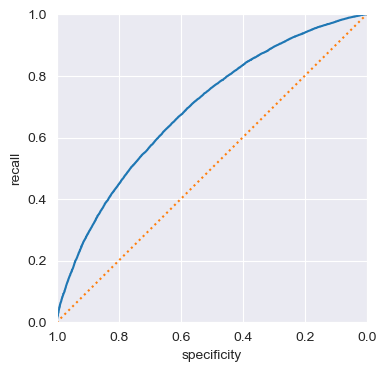

In [528]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], pos_label='default')
roc_df = pd.DataFrame({'recall':tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0), (0,1), ':')
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


In [529]:
roc_df.head()

,recall,specificity
0,0.000000,1.000000
1,0.000044,1.000000
2,0.000132,1.000000
3,0.000132,0.999956
4,0.000353,0.999956


The dotted line corresponds to a classifier no better than random chance. An extremely effective classifier (or, in medical situations, an extremely effective diagnostic test) will have an ROC that hugs the upper-left corner- it will correctly identify lots of 1s without misclassifying lots of 0s as 1s. For this model, if we want a classifier with a specificity of at least 50%, then the recall is about 75%

<b><h4>Precision-Recall Curve</h4></b>

In addition to ROC curves, it can be illuminating to examine the <em>precision_recall (PR) curve</em>. PR curves are computed in a similar way except that the data is ordered from least to most probable and cumulative precision and recall statistics are computed. PR curves are especially useful in evaluating data with highly unbalanced outcomes.

<b><h4>AUC</h4></b>

The ROC curve is a valuable graphical tool, but by itself doesnt constitute a single measure for the performance of a classifier. The ROC curve can be used, however, to produce the area under the curve (AUC) metric. AUC is simply the total area under the ROc curve. The larger the value of AUC, the more effective the classifier. An AUC of 1 indicates a perfect classifier; it gets all the 1s correctly classified, and it doesnt misclassify any 0s as 1s. A completely ineffective classifier - the diagonal line - will have an AUC of 0.5.

In Python, we can either calculate the accuracy or use scikit-learn's function sklearn.metrics.roc_auc_score(). You will need to provide the expected value as 0 or 1. The logit_reg model has an AUC of 0.69 making it a rather weak classifier. 

In [530]:
np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity))

0.6922340549747511

In [531]:
roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:,0])

0.6922341318268517

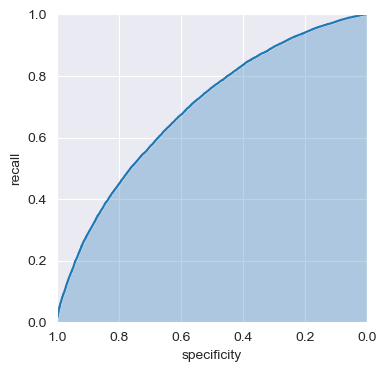

In [532]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], pos_label='default')
roc_df = pd.DataFrame({'recall':tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
# ax.plot((1,0), (0,1), ':')
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


<b><h4>Lift</h4></b>

Using the AUC as a metric to evaluate a model is an improvement over simple accuracy, as it can assess how well a classifier handles the trade-off between overall accuracy and the need to identify the more important 1s. But it does not completely address the rare-case problem, where you need to lower the model's probability cutoff below 0.5 to avoid having all records classified as 0s. In such cases, for a record to be classified as a 1, it might be sufficient to have a probability of 0.4, 0.3 or lower. In effect, we end up overidentifying 1s, reflecting their greater importance.
Changing this cutoff will improve your chances of catching the 1s (at the cost of misclassifying more 0s as 1s). But what is the optimum cutoff?

The concept of lift lets you defer answering that question. Instead, you consider the records in order of their predicted probability of being 1s. Say, of the top 10% classified as 1s, how much better did the algorithm do, compared to the benchmark of simply picking blindly? If you can get 0.3% response in this top decile insted of the 0.1% you get overall by picking randomly, the algorithm is said to have a lift (also called gains) of 3 in the top decile. A lift chart (gains chart) quantifies this over the range of the data. It can be produced decile by decile, or continuously over the range of the data.

To compute a lift chart, you first produce a cumulative gains chart that shows the recall on the y-axis and the total number of records on the x-axis. The lift curve is the ratio of the cumulative gains to the diagonal line corresponding to random selection. Decile gains charts are one of the oldest techniques in predictive modeling, dating from the days before internet commerce. They were particularly popular among direct mail professionals. Direct mail is an expensive method of advertising if applied indiscriminately, and advertisers used predictive models (quite simple ones) to identify the potential customers with the likeliest prospect of payoff.

A lift curve lets you look at the consequences of setting different probability cutoffs for classifying records as 1s. It can be an intermediate step in settling on an appropriate cutoff level. For example, a tax authority might have only a certain amount of resources that it can spend on tax audits, and it wants to spend them on the likeliest tax cheats. With its resource constraint in mind, the authority would use a lift chart to estimate where to draw the line between tax returns selected for audit and those left alone.

<b><h3>Strategies for Imbalanced Data</h3></b>

In addition to evaluation metrics that are suitable for imbalanced data - data in which the outcome of interest is rare, there are strategies that can improve predictive modeling performance with imbalanced data.

<b><h4>Undersampling</h4></b>

If you have enough data, as is the case with the loan data, one solution is to undersample (or downsample) the prevalent class, so the data to be modeled is more balanced between 0s and 1s. The basic idea in undersampling is that the data for the dominant class has many redundant records. Dealing with a smaller, more balanced data set yields benefits in model performance, and it makes it easier to prepare the data and to explore and pilot models.

How much data is enough? It depends on the application, but in general, having tens of thousands of records for the less dominant class is enough. The more easily distinguishable the 1s are from the 0s, the less data needed.

The loan data analyzed previously, was based on a balanced training set: half of the loans were paid ooff, and the other half were in default. The predicted values were similar: half of the probabilities were less than 0.5, and half were greater than 0.5. In the full data set, only about 19% of the loans were in default. We can use the full data to train the model to see what happens. In the code below only 0.15% of the loans are predicted to be in default, or less than 1/100 of the expected number. The loans that were paid off overwhelm the loans in default because the model is trained using all the data equally. Thinking about it intuitively, the presence of so many nondefaulting loans, coupled with the inevitable variability in predictor data, means that , even for a defaulting loan, the model is likely to find some nondefaulting loan that it is similar to, by chance. When a balanced sample was used, roughly 50% of the loans were predicted to be in default.

In [533]:
full_train_set = pd.read_csv('../data/full_train_set.csv.gz')
full_train_set.head()

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_
0,Fully Paid,5000,36 months,24000,27.65,8.14350,13648.0,83.7,credit_card,RENT,1,1,3,5.4,paid off,11,credit_card,RENT,> 1 Year
1,Charged Off,2500,60 months,30000,1.00,2.39320,1687.0,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year
2,Fully Paid,2400,36 months,12252,8.72,8.25955,2956.0,98.5,small_business,RENT,1,1,2,5.0,paid off,11,small_business,RENT,> 1 Year
3,Fully Paid,10000,36 months,49200,20.00,8.27585,5598.0,21.0,other,RENT,1,1,10,4.2,paid off,11,other,RENT,> 1 Year
4,Fully Paid,5000,36 months,36000,11.20,5.21533,7963.0,28.3,wedding,RENT,1,1,9,6.8,paid off,4,other,RENT,> 1 Year


In [534]:
f"percentage of loans in defaut:  {100*np.mean(full_train_set.outcome == 'default')}"

'percentage of loans in defaut:  18.894546909248504'

In [535]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

In [536]:
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', drop_first=True)
y = full_train_set[outcome]

In [537]:
full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X,y)
f"percentage of loans in defaut:  {100*np.mean(full_model.predict(X) == 'default')}"

'percentage of loans in defaut:  0.1525165226232842'

In [538]:
full_model.classes_

array(['default', 'paid off'], dtype=object)

<b><h4>Oversampling and Up/Down Weighting</h4></b>

One criticism of the undersampling method is that it throws away data and is not using all the information at hand. If you have a relatively small data set, and the rarer class contains a few hundred or a few thousand records, then undersampling the dominant class has the risk of throwing out useful information. In this case, instead of downsampling the dominant cse, you sould oversample (upsample) the rarer class by drawing additional rows with replacement (bootstrapping).

You can achieve a similar effect by weighting the data. Many classification algorithms take a weight argument that will allow you to up/down weight the data. Most scikit-lean methods allow specifying weights in the fit() function using the keyword sample_weight.

The weights for loans that default are set to $\dfrac{1}{p}$, where $p$ is the probability of default. The nondefaulting loans have a weight of 1. The sums of the weights for the defaulting loans and nondefaulting loans are roughly equal. The mean of the predicted values is now about 58% instead of 0.39%. 

Note that weighting provides an alternative to both upsampling the rarer class and downsampling the dominant class. Weighting is an easy way to adapt the loss function, discounting errors for records with low weights in favor of records with higher weights.

In [539]:
default_wt = 1/ np.mean(full_train_set.outcome == 'default')
default_wt

5.292532309999559

In [540]:
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]


In [541]:
full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y, sample_weight=wt)
f"percentage of loans predicted to defaullt (weighting): {100*np.mean(full_model.predict(X) == 'default')}"

'percentage of loans predicted to defaullt (weighting): 61.79836148916132'

<b><h4>Data Generation</h4></b>

A variation of upsampling via bootstrapping is data generation by perturbing existing records to create new records. The intuition behind this idea is that since we only observe only a limited set of instances, the algorithm doesnt have a rich set of information to build classification "rules". By creating new records that are similar but not identical to exisiting records, the algorithm has a chance to learn a more robust set of rules. This notion is similar in spirit to ensemble statistical models such as boosting and bagging. 

The idea gained traction with the publication of the SMOTE algorithm, which stands for "Synthetic Minority Oversampling Technique". The SMOTE algorithm finds a record that is similar to the record being upsampled and creates a synthetic record, where the weight is generated separately for each predictor. The number of synthetic oversampled records created depends on the oversampling ratio required to bring the data set into approximate balance with respect to outcome classes.

The Python package <em>imbalanced-learn</em> implements a variety of methods with an API that is compatible with scikit-learn. It provides various methods for over- and undersampling and support for using these techniques with boosting and bagging classifiers.

In [542]:
X_resampled, y_resampled = SMOTE().fit_resample(X,y)
f"percentage of loans in default in (SMOTE resampled) : {100 * np.mean(y_resampled == 'default')}"

'percentage of loans in default in (SMOTE resampled) : 50.0'

In [543]:
full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
f"percentage of loans predicted to default (SMOTE resampled): {100 * np.mean(full_model.predict(X) == 'default')}"

'percentage of loans predicted to default (SMOTE resampled): 29.34067857351213'

In [544]:
X_resampled, y_resampled = ADASYN().fit_resample(X,y)
f"percentage of loans in default in (ADASYN resampled) : {100 * np.mean(y_resampled == 'default')}"

'percentage of loans in default in (ADASYN resampled) : 48.56040383751355'

In [545]:
full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
f"percentage of loans predicted default (ADASYN resampled): {100 * np.mean(full_model.predict(X) == 'default')}"

'percentage of loans predicted default (ADASYN resampled): 27.39213414786602'

<b><h4>Cost-Based Classification</h4></b>

In practice, accuracy and AUC are a poor man's way to choose a classification rule. Often, an estimated cost can be assigned to false positives versus false negatives, and it is more appropriate to incorporate these costs to determine the best cutoff when classifying 1s and 0s. For example, suppose the expected cost of a default of a new loan is C and the expected return from a paid-off loan is R. Then the expected return for that loan is:

$expected\;return = P(Y=0) * R + P(Y=1)*C$

Instead of simply labeling a loan as default or paid off, or determining the probability of default, it makes more sense to determine if the loan has a positive expected return. Predicted probability of default is an intermediate step, and it must be combined with the loan's total value to determine expected profit, which is the ultimate planning metric of business. For example, a smaller value loan might be passed over in favor of a larger one with a slightly higher predicted default probability.

<b><h4>Exploring the Predictions</h4></b>



In [546]:
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [547]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state =1, criterion='entropy', min_impurity_decrease=0.003)
loan_tree.fit(X,y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X,y)

logit_reg = LogisticRegression(penalty='l2', solver='liblinear')
logit_reg.fit(X,y)

gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


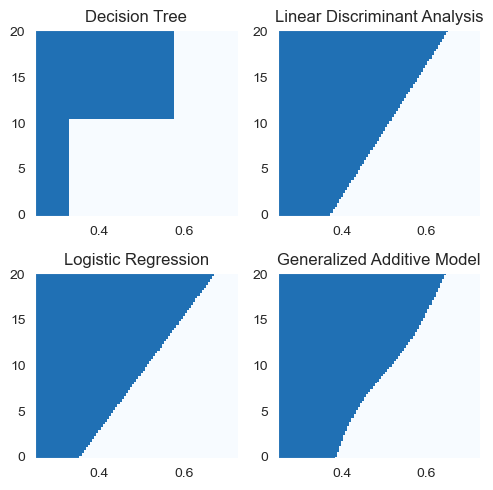

In [562]:
models = {
    'Decision Tree' : loan_tree,
    'Linear Discriminant Analysis' : loan_lda,
    'Logistic Regression' : logit_reg,
    'Generalized Additive Model' : gam
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5,5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)

X = pd.DataFrame({
    'borrower_score': xx.ravel(),
    'payment_inc_ratio': yy.ravel(),
})

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n//2, n%2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    
    Z = Z.reshape(xx.shape)
    
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    
plt.tight_layout()

In [549]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)
boundaries.head()

,Decision Tree,Linear Discriminant Analysis,Logistic Regression,Generalized Additive Model,borrower_score
0,-0.1,-0.1,-0.1,-0.1,0.250
1,-0.1,-0.1,-0.1,-0.1,0.255
2,-0.1,-0.1,-0.1,-0.1,0.260
3,-0.1,-0.1,-0.1,-0.1,0.265
4,-0.1,-0.1,-0.1,-0.1,0.270


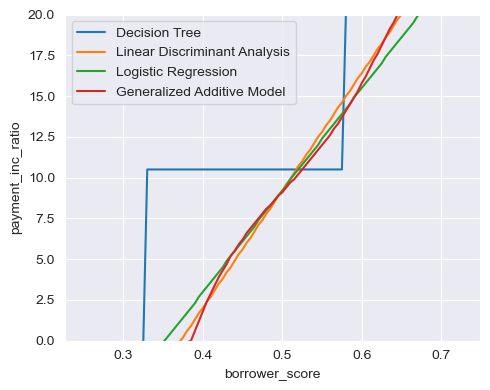

In [555]:
fig, ax = plt.subplots(figsize=(5,4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0,20)
plt.tight_layout()